In [2]:
import numpy as np
import nltk
import pickle
import re
from time import time
from gensim import corpora, models, similarities
from itertools import chain
from _datetime import datetime
from lxml import etree
import json
# from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from math import log
from pprint import pprint as pp
from string import punctuation
from collections import defaultdict, deque, OrderedDict
import pandas as pd
import numpy

C:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


**Для чтения исходных данных Excel**

In [7]:
def read_data(filename):
    """Reads the given file and creates a generator object returning one line at a time split by tabulation"""
    data = pd.read_excel(filename)
    return data

**Препроцессинг**

In [5]:
# with open('.\expectations_meter\english_stopwords.txt', 'r', encoding='utf-8') as f:
with open('.\english_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [word.strip() for word in f.readlines()]

lemmatizer = WordNetLemmatizer()

numbers = re.compile('[0-9]')
punctuation += '\n—–- «»\'\"'
lemmatization_stoplist = ['3gs', '4s', '5s', '6s']
product_lemm_reg = re.compile("(iphone|ipad|ipod|macbook|[ie]mac|air|5c|classic|nano|tv|ibook|shuffle|touch|mini|pro|powerbook)(s|es)")

def lemmatize(text, allow_stopwords=False):
    if allow_stopwords:
        current_stopwords = []
    else:
        current_stopwords = stopwords[:]
    lemmatized = [lemmatizer.lemmatize(word).lower() 
                  if not word in lemmatization_stoplist else word.lower() 
                  for word in nltk.word_tokenize(text) 
                    if word not in current_stopwords + list(punctuation)
                    and word not in ["''", ' ', '``', '', "'s"]
                ]
    product_lemmatized = [product_lemm_reg.sub('\\1', word) for word in lemmatized]
    return product_lemmatized

def preprocess(text, allow_stopwords=False):
    sentences = nltk.sent_tokenize(text)
    return [lemmatize(sent, allow_stopwords) for sent in sentences]

# def preprocess_corpus(filename):
def read_json_texts(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return json.loads(f.read())
    
def preprocess_texts(text_list):
    return [preprocess(text) for text in texts_list]

def preprocess_corpus(filename, serialize=''):
    data = read_data(filename)
    bodies = []
    dates = parse_dates(data['datetime'])
    for index, (title, body, author, datetime) in data.iterrows():
        if not pd.isnull(body):
            bodies.append(preprocess(body))
    output_dict = {'texts': bodies, 'dates': dates}
    if serialize:
        with open(serialize, 'wb') as f:
            pickle.dump(output_dict, f)
    return output_dict

def read_pickled_corpus(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
# app_ins_data = preprocess_corpus('.\DATA\AppleInsider.xlsx', serialize='.\DATA\AppleInsiderData.pickle')
# app_ins_data = read_pickled_corpus('.\DATA\AppleInsiderData.pickle')
# app_ins_data

    
preprocess('iPhone 5s', allow_stopwords=True)

[['iphone', '5s']]

**Для получения токенизированных и лемматизированных данных и дат из корпуса**

In [10]:
def get_corpus(filename):
    # data = read_data(filename).iloc[:1000]
    data = read_data(filename)
    dates = data['datetime']
    # bodies = [preprocess(text) for text in list(data['body']) if not pd.isnull(text)]
    # titles = [preprocess(text) for text in list(data['title']) if not pd.isnull(text)]
    bodies = []
    for index, (title, body, author, datetime) in data.iterrows():
        if not pd.isnull(body):
            bodies.append(preprocess(body))
    return bodies, dates

**Парсим даты**

In [9]:
from datetime import datetime

def parse_date(date_string, product_list=False):
    # date_only = date_string[:10]
    # '2009-01-01 08:25:07'
    # 2012-01-17T17:57:00-05:00
    # Friday November 10, 2006 10:49 pm PST
    # November 2, 2012 - product list
    if not product_list:
        if 'T' not in date_string:
            date = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S').date()
        elif 'pst' in date_string.lower() or 'pdt' in date_string.lower():
            date = datetime.strptime(date_string[:-4], '%A %B %d, %Y %H:%M %p').date()
        else:
            date = datetime.strptime(date_string[:-6], '%Y-%m-%dT%H:%M:%S').date() 
    else:
        date = datetime.strptime(date_string, '%B %d, %Y').date()
    return date
date = parse_date('November 2, 2012', True)
article_date = parse_date('Friday March 10, 2016 10:49 pm PST')

print(date, article_date, (article_date - date).days)
def parse_dates(dates):
    return [parse_date(date) for date in dates]

2012-11-02 2016-03-10 1224


**Функции для поиска ключевых слов в тексте **

In [11]:
def mark_text(words, text):
    for word in words:
        text = text.replace(word, '[<' + word + '>]')
    return text

def search_words(keywords, text):
    tokens = preprocess(text)
    keywords = set(list(chain(*preprocess(keywords))))
    intersection = list(keywords.intersection(set(list(chain(*tokens)))))
    if intersection:
        return intersection, mark_text(intersection, text), tokens

**Список всех продуктов**

Считываем список всех продуктов Apple из стороннего файла. Создаем список из tuples. Убираем все упоминания числа гигабайт в моделях, а так же типов сотовой связи, и времени выхода в году

In [14]:
def make_product_tuple(product_full_name):
    name_cleaned = ''.join([char for char in product_full_name.lower() if not char in '()\'"&']).split()
    parts_to_remove = ['gb', '+', 'with', 'wcdma', 'cdma', 'gsm', '16', '32', '64', '128']
    name_cleaned = tuple([re.sub('([0-9])(rd|st|nd|th)', '\\1', word) for word in name_cleaned if not word in parts_to_remove])
    return name_cleaned

def make_product_regex(product_full_name, min_req):
    product_tuple = make_product_tuple(product_full_name)
    product_regex = ''
    for i in range(len(product_tuple)):
        if i < min_req:
            product_regex += '\ ({})'.format(product_tuple[i])
        else:
            product_regex += '(\ *{})?'.format(product_tuple[i])
    modifiers = """(?P<new_products>  # a group for the words reffering to new and upcoming products
            new(?:est)?|(?:up)?coming|to\ *?be\ *?ann?ounced|updated?|
            (next\ *?-?\ *?(?:gen(?:eration)?|year)?)
       )?
       (?P<launched_products> # a group for the words reffering to the old or already launched products
           (?: (current|last|previous)\ *?-?\ *?(?:gen(?:eration)?|year)?)
           |(?:this\ *?-?\ *?(?:gen(?:eration)?|year)?)
       )?\ *?"""
    product_regex = modifiers +  product_regex.strip()
    return re.compile(product_regex.strip(), re.X)

def read_product_list(product_list_file):
    models = defaultdict(lambda: defaultdict(list))
    product_list = read_data(product_list_file)
    for i, (year, launched, date_launched, model_full, keywords, inter_req, model_group, family) in product_list.iterrows():
        product = make_product_regex(keywords, inter_req)
        date = parse_date(date_launched, True)
        model_group = ' '.join(model_group.split())
        if not product in models[date][model_group]:
            models[date][model_group].append((product, inter_req))
    return models

# product_list = read_product_list('.\expectations_meter\DATA\Apple_produt_list_devices_only.xlsx')
product_list = read_product_list('.\DATA\Apple_produt_list_withour_dicsontinuation.xlsx')
product_list

defaultdict(<function __main__.read_product_list.<locals>.<lambda>>,
            {datetime.date(2000, 2, 16): defaultdict(list,
                         {'PowerBook ("Pismo")': [(re.compile(r'(?P<new_products>  # a group for the words reffering to new and upcoming products\n            new(?:est)?|(?:up)?coming|to\ *?be\ *?ann?ounced|updated?|\n            (next\ *?-?\ *?(?:gen(?:eration)?|year)?)\n       )?\n       (?P<launched_products> # a group for the words reffering to the old or already launched products\n           (?: (current|last|previous)\ *?-?\ *?(?:gen(?:eration)?|year)?)\n           |(?:this\ *?-?\ *?(?:gen(?:eration)?|year)?)\n       )?\ *?\ (powerbook)\ (pismo)',
                            re.UNICODE|re.VERBOSE),
                            3)]}),
             datetime.date(2000, 7, 19): defaultdict(list,
                         {'Power Mac G4 Cube': [(re.compile(r'(?P<new_products>  # a group for the words reffering to new and upcoming products\n            new(?:es

**Поиск упоминаний продуктов из списка в корпусе**.

In [142]:
def find_mention(tokenized_text, regex):
    text_string = ' '.join(tokenized_text)
    matches = regex.finditer(text_string)
    return matches

def delete_intersections(product_mentions):
    pm = sorted(product_mentions, key=lambda x: (x[2].start(), -x[2].end()))
    first_mention = pm[0]
    filtered = [first_mention]
    p_product, p_launch_date, (p_start, p_end) = first_mention[0], first_mention[1], first_mention[2].span()
    for mention in pm[1:]:
        product, launch_date, (start, end) = mention[0], mention[1], mention[2].span()
        last_added_span = tuple(filtered[-1][-1].span())
        if product != p_product and (end > p_end or start > p_end or (start, end) == last_added_span):
            filtered.append(mention)
    return filtered

def sort_by_date(product_mentions, article_date):
    launched_products =  []
    upcoming_products =  []
    for mention in product_mentions:
        product, launch_date, match = mention
        has_new_word = match.group('new_products')
        has_launched_word = match.group('launched_products')
        if launch_date >= article_date:
            if not has_launched_word and has_new_word:
                upcoming_products.append(mention)
        elif launch_date < article_date:
            if not has_new_word and has_launched_word:
                launched_products.append(mention)
            else:
                if (article_date - launch_date).days < 50 and has_new_word:
                    launched_products.append(mention)
    return launched_products, upcoming_products

def search_products(tokenized_sents, product_list, article_date):
    marked_text = ''
    launched_products =  []
    upcoming_products =  []
    for sent in tokenized_sents:
        mentions = []
        for launch_date in product_list:
            if -365 < (article_date - launch_date).days < 365:
                for product, regexs in product_list[launch_date].items():
                    for regex, _ in regexs:
                        search_results = find_mention(sent, regex)  
                        mentions.extend([[product, launch_date] + [sr] for sr in search_results])
        if mentions:
            mentions = delete_intersections(mentions)
            cur_launched_products, cur_upcoming_products = sort_by_date(mentions, article_date)
            launched_products.extend(cur_launched_products)
            upcoming_products.extend(cur_upcoming_products)
    return launched_products, upcoming_products

# def count_product_mentions(mentions):
#     return sum([mention.])

def get_unique_mentions(mentions):
    return list(set([m[0] for m in mentions]))

def find_mentions(dates, texts):
    mentions = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for article_date, (id, sents) in zip(dates, enumerate(texts)):
        year = article_date.year
        month = article_date.month
        year_month = datetime(year, month, 1).date()
        launched_mentions, upcoming_mentions  = search_products(sents, product_list, article_date)
        # print(date, year, products_mentioned)
        for mention in get_unique_mentions(upcoming_mentions):
            product_name = mention
            if 'text_ids' in  mentions[product_name][year_month]:
                if id not in mentions[product_name][year_month]['text_ids']:
                    mentions[product_name][year_month]['text_ids'].append(id)
                    mentions[product_name][year_month]['number'] += 1
            else:
                mentions[product_name][year_month]['text_ids'] = [id]
                mentions[product_name][year_month]['number'] += 1
    return mentions

# text = """ The iphone 5s"""
# date = parse_date('2013-10-12 16:30:45')
# search_products(preprocess(text), product_list, date)

In [128]:
# def count_product_mentions(mentions):
#     return sum([mention.])

def get_unique_mentions(mentions):
    return list(set([m[0] for m in mentions]))

def find_mentions(dates, texts):
    mentions = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for article_date, (id, sents) in zip(dates, enumerate(texts)):
        year = article_date.year
        month = article_date.month
        year_month = datetime(year, month, 1).date()
        launched_mentions, upcoming_mentions  = search_products(sents, product_list, article_date)
        # print(date, year, products_mentioned)
        for mention in get_unique_mentions(upcoming_mentions):
            product_name = mention
            if 'text_ids' in  mentions[product_name][year_month]:
                if id not in mentions[product_name][year_month]['text_ids']:
                    mentions[product_name][year_month]['text_ids'].append(id)
                    mentions[product_name][year_month]['number'] += 1
            else:
                mentions[product_name][year_month]['text_ids'] = [id]
                mentions[product_name][year_month]['number'] += 1
    return mentions

In [147]:
with open('./DATA/apple_product_releases.json', 'r', encoding='utf-8') as f:
    product_releases = json.loads(f.read())
for name, desc, date:
    print()

[['Apple Special Event, October 2016 (1080p)',
  'MacBook Pro, Final Cut Pro X update, TV app for Apple TV, iPhone and iPad',
  '10/27/2016'],
 ['Apple Special Event, September 2016 (1080p)',
  'iPhone 7, iPhone 7 Plus, AirPods, Apple Watch Series 2, Apple Watch Hermès and Apple Watch Nike+',
  '9/9/2016'],
 ['Apple WWDC 2016 Keynote Address (1080p)',
  'iOS 10, macOS Sierra, watchOS 3 and Swift Playgrounds app',
  '6/13/2016'],
 ['Apple Special Event, March 2016 (1080p)',
  '9.7-inch iPad Pro, iPhone SE, Apple Watch and tvOS Updates',
  '3/21/2016'],
 ['Apple Special Event, September 2015 (1080p)',
  'iPhone 6s & iPhone 6s Plus, the all-new Apple TV with tvOS, iPad Pro, WatchOS 2 and iOS 9',
  '9/10/2015'],
 ['Apple WWDC 2015 Keynote Address (1080p)',
  'Apple Music, OS X El Capitan, watchOS 2, iOS 9, News app, updates to Apple Pay',
  '6/8/2015'],
 ['Apple Special Event, March 2015 (1080p)',
  'Apple Watch, MacBook, ResearchKit, HBO NOW',
  '3/9/2015'],
 ['Apple Special Event, Octobe

**Визуализация**

Визуализируем распределение упоминаний продуктов по датам

In [139]:
import matplotlib.pyplot as plt
def plot_mentions(mentions, dates):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    legend = []
    for product in mentions:
        if 'iphone' in product.lower():
            ment_numbers = [mentions[product][datetime(date.year, date.month, 1).date()]['number'] 
                            if datetime(date.year, date.month, 1).date() in mentions[product] else 0 for date in dates]
            plt.plot(dates, ment_numbers)
            legend.append(product)
    plt.legend(legend)
    plt.show()

**Собираем все вместе**

In [14]:
product_list = read_product_list('.\expectations_meter\DATA\Apple_produt_list_devices_only.xlsx')
product_list[2009]['MacBook Pro (4th gen) 2016']

[]

In [150]:
# app_ins_data = preprocess_corpus('.\DATA\AppleInsider.xlsx', serialize='.\DATA\AppleInsiderData.pickle')
# app_ins_data = read_pickled_corpus('.\DATA\AppleInsiderData.pickle')

nfm_data = preprocess_corpus('.\DATA\\NineToFiveMac.xlsx', serialize='.\DATA\\NineToFiveMacData.pickle')
# nfm_data = read_pickled_corpus('.\DATA\NineToFiveMacData.pickle')

mcr_data = preprocess_corpus('.\DATA\MacRummors.xlsx', serialize='.\DATA\\MacRummorsData.pickle')
# mcr_data = read_pickled_corpus('.\DATA\MacRummorsData.pickle')

In [145]:
num = 10000
appins_mentions = find_mentions(app_ins_data['dates'][:num], app_ins_data['texts'][:num])


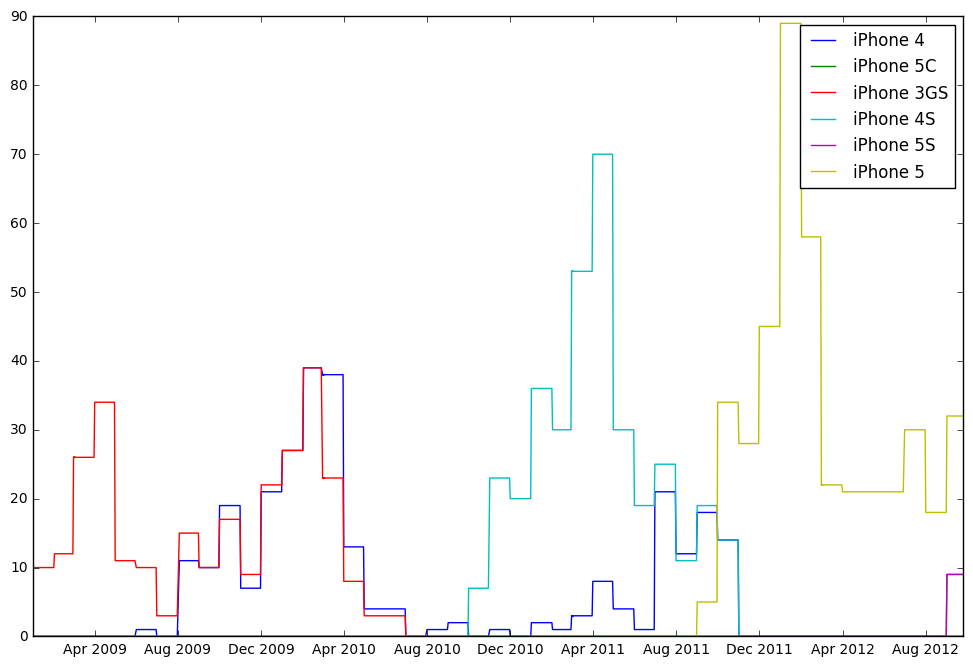

In [146]:
plot_mentions(appins_mentions, app_ins_data['dates'][:num])